#Density Sensitive projection

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
from sklearn import random_projection
from itertools import groupby
from heapq import heappush, heappop
import random
from sklearn import svm
from pylab import rcParams
from sklearn.utils.extmath import safe_sparse_dot

# Use seaborn styles for nice-looking plots
import seaborn; seaborn.set()

# Define some functions
def plotHyperplane(normal, intercept=0, label='', plt=plt):
    """ Plot a hyperplane given a normal and an intercept
    """
    a = -normal[0] / normal[1]
    xx = np.linspace(-10, 10)
    yy = a * xx - (intercept) / normal[1]    
    plt.plot(xx, yy, label=label)    
    return 0

def hashWithMedianPlane(p, X):
    """ hash using median plane
    """
    w = p[0] - p[1]    
    t = np.dot((p[0]+p[1])/2,w)
    
    res = np.inner(w, X)    
    
    return ['1' if elem >= t else '0' for elem in res]


def medianPlane(p):
    """Generate median plane given two points
    """    
    median = (p[0]+p[1]) / 2
    diff = p[0] - p[1]
    
    # hyperplane    
    intercept = -np.dot(median,diff)    

    return (diff, intercept)

def generateBitString( x ):
    return "".join(['1' if i > 0 else '0' for i in x])

class HashBucketScreening:
    """HashBucketScreening class"""    
    
    def __init__(self, features, rnd=42,maxplanes=40,strategy='median'):
        self.maxplanes = maxplanes
        rng = np.random.RandomState(rnd) 
        self.randomProjection = random_projection.gaussian_random_matrix(1, features, random_state=rng)        
        self.strategy = strategy
        
    def _generateHyperplaneUsingSVM(self, X, Y):
        """ Here we estimate the seperating hyperplane using svm
        """
        plane = svm.SVC(kernel='linear', C=2)
        plane.fit(X,Y)
                
        return (plane, plane.coef_[0], plane.intercept_[0])
                
    def screen(self, X, Y):

        # Now generate a random plane through the origin - start of the algorithm
        # medians stores the hyperplane normals as well as intercepts                                   
        self.medians = [(self.randomProjection[0], 0)]   
                
        # Project #1
        projected = safe_sparse_dot(X, self.randomProjection.T)
        self.buckets = np.apply_along_axis( generateBitString, axis=1, arr=projected )

        plane = 1        
        
        self.select = []

        # This is the algorithm
        while True:          
            
            heap = []
            
            for key in np.unique(self.buckets):
                # estimate pos ratio        
                qualifying = Y[self.buckets == key]
                length = qualifying.shape[0]   
                pos = qualifying[qualifying == 1].shape[0]
                #print('Buckets', key, pos)        
                ratio = min(pos / length, (length - pos) / length)
                #print(key,ratio,length)
                if 0 < ratio < 0.5:
                    # Take buckets which need splitting - weight them by the number of points
                    heap.append(( length * ratio, key, pos, length))    

            if (len(heap) == 0) or (plane > self.maxplanes) :
                print('No more elements')
                break;                

            heap = sorted(heap, key=lambda x: x[0])         
            
            #print(heap)
            
            # select the bucket that needs splitting
            # get the smalles element 
            #largest = heap[0]#.pop()
            largest = heap.pop()

            # 3 strategies
            # Take random points 1) or 2) take the median of all pos/neg points each, simulates k-means

            # now from this "largest bucket" sample 1 pos and 1 neg point
            #qualifyingPos = random.choice(X[(buckets == largest[1]) & (Y == 1)])
            #qualifyingNeg = random.choice(X[(buckets == largest[1]) & (Y != 1)])

            # Strategy 2 take median of qualifying points
            if(self.strategy == 'median'):
                qualifyingPos = np.median(X[(self.buckets == largest[1]) & (Y == 1)],axis=0)
                qualifyingNeg = np.median(X[(self.buckets == largest[1]) & (Y != 1)],axis=0)
                median = (qualifyingPos, qualifyingNeg)
                
                # Store the median points
                self.medians.append(medianPlane(median))                

                # add the new bitstring to the hash
                self.buckets = np.core.defchararray.add(self.buckets, hashWithMedianPlane(median, X))

            
            if(self.strategy == 'SVM'):
                # Strategy 3 use SVM to find seperating hyperplane per bucket
                (svm, point, intercept) = self._generateHyperplaneUsingSVM(
                    X[self.buckets == largest[1]], Y[self.buckets == largest[1]])
                
                if(np.array_equal(point, self.medians[-1][0]) & (intercept == self.medians[-1][1])):
                    print('We have the same hyperplane .. going in circles, breaking')
                    break
                
                self.medians.append((point,intercept))
                
                newbit = ['1' if elem > 0 else '0' for elem in svm.decision_function(X)]                                

                self.select.append(X[self.buckets == largest[1]])
                
                self.buckets = np.core.defchararray.add(self.buckets, newbit)                                

                
            plane = plane + 1            
            
        print('Done after %d planes' % (plane))
        
    def getBucketSamples(self,X,Y,samples=2):
        """ Samples from all buckets #samples points
        """
        # Also just sample n point from all buckets
        sampledPoints = []
        data = np.column_stack((self.buckets, Y, X))   
        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            #sampledPoints.append(random.choice(list(rows)))
            l = list(rows)
            sampledPoints.extend(random.sample(l,min(samples,len(l))))

        sampledPoints = np.asarray(sampledPoints)     
        return sampledPoints
    
    def getHammingSamples(self,X,Y):
        """ Get all points that belong to hamming buckets that are support buckets
        """        
        data = np.column_stack((self.buckets, Y))  
        keySize = len(list(groupby(data[np.argsort(data[:,0])], lambda x: x[0])))

        X_hamming = np.empty([keySize, len(self.buckets[0])])
        Y_hamming = [0] * keySize
        counter = 0

        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            row = list(rows)        
            pos = len(list(filter(lambda x: x[1] == '1.0', row)))
            neg = len(list(filter(lambda x: x[1] != '1.0', row)))
                        
            X_hamming[counter:] = np.array(list(map(int, key))) 
            Y_hamming[counter] = 1 if pos > neg else 0
            counter = counter + 1   
    
        # Create Hamming Points and run SVM
        clf = svm.SVC(kernel='linear', C=2)
        clf.fit(X_hamming, Y_hamming)

        #print('Support Vectors:\n', clf.support_vectors_)
        print('All hamming points %d - reduced to %d' % (keySize, len(clf.support_vectors_)))
        
        self.selected = np.apply_along_axis( generateBitString, axis=1, arr=clf.support_vectors_)

        reduced_x = X[np.in1d(self.buckets, self.selected)]
        reduced_y = Y[np.in1d(self.buckets, self.selected)]        
        
        return (reduced_x, reduced_y)
    
    def getHammingSupportSamples(self, X, Y, samples):                
        data = np.column_stack((screen.buckets, Y, X))   
        sampledSupportBucket = []
        # Sample points from the support buckets only
        for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
            if key in self.selected:
                l = list(rows)
                sampledSupportBucket.extend(random.sample(l,min(samples,len(l))))

        sampledSupportBucket = np.asarray(sampledSupportBucket)   
                
        return (sampledSupportBucket[:,2:], sampledSupportBucket[:,1])
    
    def getPointsPerBucket(self, X, Y):
        dist = []
        for key in np.unique(self.buckets):
            qualifying = Y[self.buckets == key]
            pos = qualifying[qualifying == 1].shape[0]
            dist.append((key, qualifying.shape[0], pos, qualifying.shape[0] - pos))
        
        return dist

In [65]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 10
n_samples_2 = 10
X = np.r_[1 * rng.randn(n_samples_1, 2) - [2,2],
          1 * rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

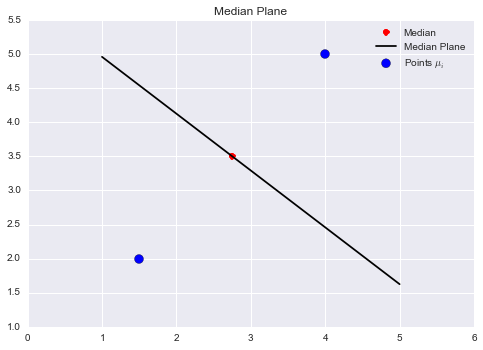

In [3]:
# Show the base of the algorithm
p = np.array( [ (1.5,2), (4,5) ] )

plt.scatter(p[:, 0], p[:, 1], s=80,
                 zorder=10, label='Points $\mu_i$')

# median of the centers
median = (p[0]+p[1]) / 2
diff = p[0] - p[1]
plt.plot(median[0],median[1], 'ro', label='Median')

# hyperplane
a = -diff[0] / diff[1]
intercept = -np.dot(median,diff)

xx = np.linspace(1, 5)
yy = a * xx - (intercept) / diff[1]

plt.plot(xx, yy, 'k-', label='Median Plane')
plt.title('Median Plane')
plt.legend()
plt.show()

Define Median Plane as $(x - \frac{\mu_i+\mu_j}{2})^T (\mu_i - \mu_j) = 0$

In [4]:
# Now generate some random points
rng = np.random.RandomState(42)
n_samples_1 = 200
n_samples_2 = 200
X = np.r_[1 * rng.randn(n_samples_1, 2) - [2,2],
          1 * rng.randn(n_samples_2, 2) + [2, 2]]
Y = np.array([0] * (n_samples_1) + [1] * (n_samples_2))

No more elements
Done after 4 planes
Wall time: 21 ms


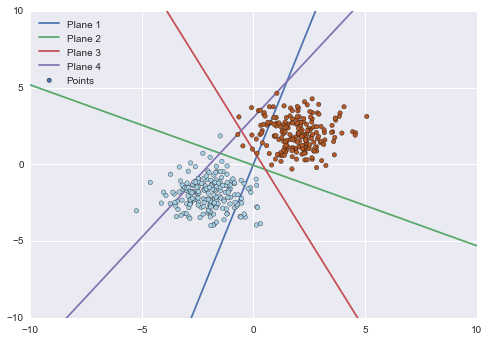

We need 5 bits to seperate all points


In [5]:
# Screen
screen = HashBucketScreening(X.shape[1], strategy='median')

%time screen.screen(X,Y)

plt.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
   
plane = 1
for (point, intercept) in screen.medians:
    plotHyperplane(point, intercept, 'Plane ' + str(plane))
    
    plane = plane + 1
    
plt.legend(loc='upper left')
plt.ylim([-10,10])
plt.xlim([-10,10])
plt.show()

print('We need %d bits to seperate all points' % (plane ))

Generate Hamming points and label based on majority

In [6]:
keySize = np.unique(screen.buckets).shape[0]

X_hamming = np.empty([keySize, len(screen.buckets[0])])
Y_hamming = [0] * keySize
counter = 0

for key in np.unique(screen.buckets):
    qualifying = Y[screen.buckets == key]      
    pos = qualifying[qualifying == 1].shape[0]
    neg = qualifying[qualifying != 1].shape[0]
    X_hamming[counter:] = np.array(list(map(int, key))) 
    Y_hamming[counter] = 1 if pos > neg else 0
    counter = counter + 1   
    
# Create Hamming Points and run SVM
clf = svm.SVC(kernel='linear')
clf.fit(X_hamming, Y_hamming)

#print('Support Vectors:\n', clf.support_vectors_)
print('All hamming points %d - reduced to %d' % (keySize, len(clf.support_vectors_)))

All hamming points 8 - reduced to 6


##Testing on generated data

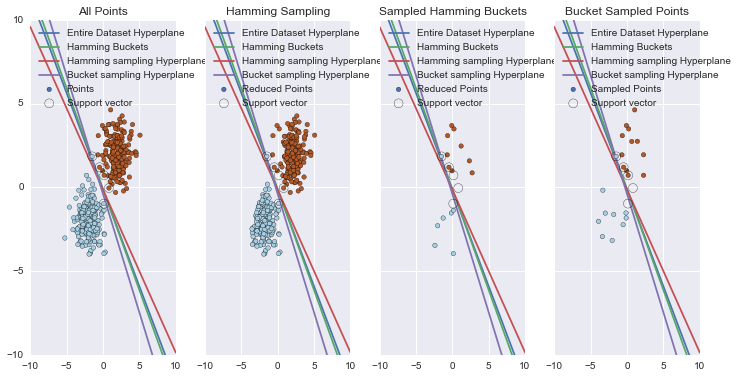

We have 5 support vectors in hamming space 
Stats
All points 400 - hamming buckets 359  (89.75 %) - hamming sampled 16 (4.00 %) - bucket sampled 22 (5.50 %)


In [7]:
selected = np.apply_along_axis( generateBitString, axis=1, arr=clf.support_vectors_)

reduced_x = X[np.in1d(screen.buckets, selected)]
reduced_y = Y[np.in1d(screen.buckets, selected)]


# Also just sample n point from all buckets
sampledPoints = []
data = np.column_stack((screen.buckets, X, Y))   
for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    #sampledPoints.append(random.choice(list(rows)))
    l = list(rows)
    sampledPoints.extend(random.sample(l,min(3,len(l))))

sampledPoints = np.asarray(sampledPoints)     

sampledSupportBucket = []
# Sample points from the support buckets only
for key, rows in groupby(data[np.argsort(data[:,0])], lambda x: x[0]):
    if key in selected:
        l = list(rows)
        sampledSupportBucket.extend(random.sample(l,min(3,len(l))))

sampledSupportBucket = np.asarray(sampledSupportBucket)     

rcParams['figure.figsize'] = (12.0, 6.0)
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, sharey=True, sharex=True)

# Now check if we still hit the same accuray
entire = svm.SVC(kernel='linear')
entire.fit(X,Y)
reduced = svm.SVC(kernel='linear')
reduced.fit(reduced_x, reduced_y)

sSampled = svm.SVC(kernel='linear')
sSampled.fit(sampledSupportBucket[:, [1,2]].astype(float), sampledSupportBucket[:,3].astype(int))

bSampled = svm.SVC(kernel='linear')
bSampled.fit(sampledPoints[:, [1,2]].astype(float), sampledPoints[:,3].astype(int))

ax1.scatter(X[:, 0], X[:, 1], c=Y, zorder=10, cmap=plt.cm.Paired, label='Points')
ax1.set_title('All Points')

ax2.scatter(reduced_x[:, 0], reduced_x[:, 1], c=reduced_y, zorder=10, cmap=plt.cm.Paired, label='Reduced Points')
ax2.set_title('Hamming Sampling')

ax3.scatter(sampledSupportBucket[:, 1], sampledSupportBucket[:, 2], c=sampledSupportBucket[:,3].astype(int), zorder=10, cmap=plt.cm.Paired, label='Reduced Points')
ax3.set_title('Sampled Hamming Buckets')

ax4.scatter(sampledPoints[:, 1], sampledPoints[:, 2], c=sampledPoints[:,3].astype(int),
            zorder=10, cmap=plt.cm.Paired, label='Sampled Points')
ax4.set_title('Bucket Sampled Points')


for plot in [ax1, ax2, ax3, ax4]: 
    plotHyperplane(entire.coef_[0],entire.intercept_[0],plt=plot,label='Entire Dataset Hyperplane')
    plotHyperplane(reduced.coef_[0],reduced.intercept_[0], plt=plot, label='Hamming Buckets')
    plotHyperplane(sSampled.coef_[0],sSampled.intercept_[0], plt=plot, label='Hamming sampling Hyperplane')
    plotHyperplane(bSampled.coef_[0],bSampled.intercept_[0], plt=plot, label='Bucket sampling Hyperplane')
    plot.scatter(entire.support_vectors_[:, 0], entire.support_vectors_[:, 1], s=80,
                facecolors='none', zorder=10, label='Support vector')
    
    plot.legend(loc='upper left')
    
plt.xlim([-10,10])
plt.ylim([-10,10])    
plt.show()


print('We have %d support vectors in hamming space ' % (len(entire.support_vectors_)))

print('Stats\nAll points %d - hamming buckets %d  (%.2f %%) - hamming sampled %d (%.2f %%) - bucket sampled %d (%.2f %%)' % 
      (len(X), 
       len(reduced_x), 
       (len(reduced_x)/len(X)) * 100, 
       len(sampledSupportBucket),
       (len(sampledSupportBucket)/len(X)) * 100,
       len(sampledPoints), 
       (len(sampledPoints)/len(X)) * 100))

In [8]:
# Now check if we still hit the same accuray

print ('Classification accuracy on the entire dataset with all     points  %f ' % (entire.score(X,   Y)))
print ('Classification accuracy on the entire dataset with hamming points  %f ' % (reduced.score(X,  Y)))
print ('Classification accuracy on the entire dataset with hamming sampled %f ' % (sSampled.score(X, Y)))
print ('Classification accuracy on the entire dataset with buckets sampling %f ' % (bSampled.score(X, Y)))

Classification accuracy on the entire dataset with all     points  0.997500 
Classification accuracy on the entire dataset with hamming points  0.997500 
Classification accuracy on the entire dataset with hamming sampled 0.997500 
Classification accuracy on the entire dataset with buckets sampling 0.997500 


No more elements
Done after 30 planes
Wall time: 98.1 ms


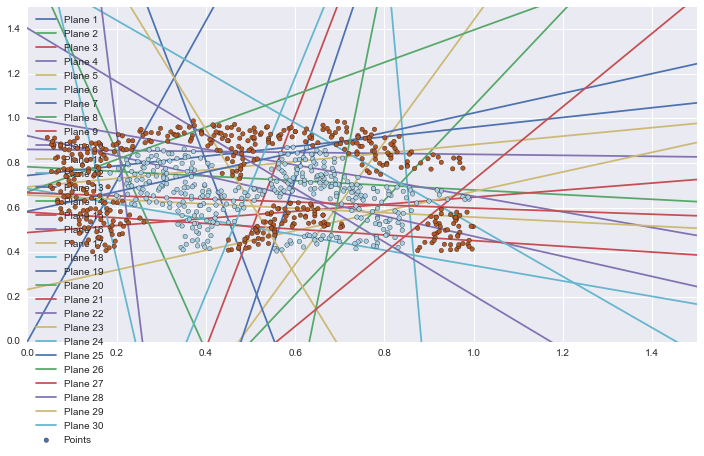

We need 31 bits to seperate all points


In [67]:
import scipy.io
data2 = scipy.io.loadmat('ex6data2.mat')    
    
# Screen
screen = HashBucketScreening(X.shape[1], strategy='median')

%time screen.screen(data2['X'], data2['y'].ravel())

plt.scatter(data2['X'][:,0], data2['X'][:,1], c=(data2['y'].flatten()), zorder=10, cmap=plt.cm.Paired, label='Points')
   
plane = 1
for (point, intercept) in screen.medians:
    plotHyperplane(point, intercept, 'Plane ' + str(plane))
    
    plane = plane + 1
    
plt.legend(loc='upper left')
plt.xlim([0, 1.5])
plt.ylim([0, 1.5])
plt.show()

print('We need %d bits to seperate all points' % (plane ))

In [73]:
# Try a larger dataset
import urllib
from sklearn.datasets import load_svmlight_file

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/liver-disorders_scale'
training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/mushrooms'
#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/skin_nonskin'
#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide1'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/splice_scale'
#testing  = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/splice.t'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide3'
#testing = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/svmguide3.t'

#training = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon'
#testing = 'http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/madelon.t'

(X_train, Y_train) = load_svmlight_file(urllib.request.urlopen(training))
(X_test, Y_test) = (X_train, Y_train)
#(X_test, Y_test) = load_svmlight_file(urllib.request.urlopen(testing))

#(X_train, Y_train) = load_svmlight_file('./data/higg_lo_svm.csv')
#(X_test, Y_test) = load_svmlight_file('./data/higg_lo_svm_test.csv')


#load_svmlight_file()

print(X_train.shape)
print(X_test.shape)

(8124, 112)
(8124, 112)


In [74]:
import math
screen = HashBucketScreening(X_train.shape[1],strategy='median')

print(X_train.shape, Y_train.shape)
%time screen.screen(X_train.toarray(), Y_train)

sPoints = screen.getBucketSamples(X_train.toarray(), Y_train,samples = 1)
                    
(r_x, r_y) = screen.getHammingSamples(X_train.toarray(), Y_train)

(s_x, s_y) = screen.getHammingSupportSamples(X_train.toarray(), Y_train, 1)

        
reducedPoints = svm.SVC(kernel='linear')
reducedPoints.fit(r_x, r_y)    

supportBucketSampled = svm.SVC(kernel='linear')
supportBucketSampled.fit(s_x, s_y.astype(float))    
    
bs = svm.SVC(kernel='linear')
bs.fit(sPoints[:, 2:].astype(float), sPoints[:,1].astype(float))    

d = svm.SVC(kernel='linear')
%time d.fit(X_train,Y_train)

print ('Classification accuracy on the entire dataset with all     points  %f ' % (d.score(X_test.toarray(),   Y_test)))
print ('Classification accuracy on the entire dataset with hamming points  %f ' % (reducedPoints.score(X_test.toarray(),   Y_test)))
print ('Classification accuracy on the entire dataset with sampled hamming %f ' % (supportBucketSampled.score(X_test.toarray(),  Y_test)))
print ('Classification accuracy on the entire dataset with buckets points  %f ' % (bs.score(X_test.toarray(),  Y_test)))

print('Stats\nAll points %d - hamming points %d  (%.2f %%) - sampled hamming %d (%.2f %%) - bucket sampled %d (%.2f %%)' % 
      (X_train.shape[0], 
       len(r_x),(len(r_x)/X_train.shape[0]) * 100,
       len(s_x),(len(s_x)/X_train.shape[0]) * 100,       
       len(sPoints),(len(sPoints)/X_train.shape[0]) * 100))

(8124, 112) (8124,)
No more elements
Done after 15 planes
Wall time: 395 ms
All hamming points 287 - reduced to 92
Wall time: 226 ms
Classification accuracy on the entire dataset with all     points  1.000000 
Classification accuracy on the entire dataset with hamming points  0.935007 
Classification accuracy on the entire dataset with sampled hamming 0.935377 
Classification accuracy on the entire dataset with buckets points  0.999508 
Stats
All points 8124 - hamming points 1728  (21.27 %) - sampled hamming 92 (1.13 %) - bucket sampled 287 (3.53 %)
